In [24]:
%matplotlib inline
import d2lzh as d2l #d2l做了一些为了方便的外部封装
from mxnet import autograd,gluon,init,nd  #mxnet里边放了很多数学工具
from mxnet.gluon  import data as gdata,loss as gloss,nn #数据读取，损失函数，和层gluon里边放的东西是最重要的
#为了让出现过拟合的情况，训练数据给的特别少
n_train,n_test,num_inputs = 20 ,100 ,200
#设置权重和偏差,nd.ones返回数据都为1的数组
true_w,true_b = nd.ones((num_inputs,1))*0.01 ,0.05



In [25]:
'''提供一下训练数据'''
#创建样本和标签
features = nd.random.normal(shape=(n_train+n_test,num_inputs))
#把labels组装出来，再加上噪音
labels = nd.dot(features,true_w) + true_b;
labels += nd.random.normal(scale=0.01,shape=labels.shape)
#最后训练和测试截取的是行的部分
train_features,test_features = features[:n_train,:],features[n_train:,:]
train_labels,test_labels = labels[:n_train],labels[n_train:]


In [26]:
'''从零开始实现'''
'''初始化模型参数'''
def init_params():
    w = nd.random.normal(scale=1,shape=(num_inputs,1))
    b = nd.zeros(shape=(1,))
    #申请存储梯度所需要的内存
    w.attach_grad()
    b.attach_grad()
    return [w,b]

'''定义L2范数惩罚项目'''
def l2_penalty(w):
    return (w**2).sum()/2

'''定义模型和损失函数，初始化数据'''
#定义如何再训练数据集和测试数据集上分别训练和测试模型
#不同的是，在计算最终的损失函数的时候，添加了L2范式惩罚项
#batch_size：一个循环读入的小批量数据
#num_epochs：迭代周期，我们把所有数据用几遍
#lr：优化算法时用到的学习率
batch_size,num_epochs,lr = 1,100,0.003 
#定义模型和定义损失函数
net,loss = d2l.linreg ,d2l.squared_loss
#读取数据集
train_iter = gdata.DataLoader(gdata.ArrayDataset(
train_features, train_labels), batch_size, shuffle=True)

'''训练'''
#lambd是权重衰减的超参数
def fit_and_plot(lambd):
    #开始训练部分
    w, b = init_params()
    #给训练误差和泛化误差屯值
    train_ls,test_ls = [],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                #添加L2范数惩罚项，广播机制使其变成长度为batch_size的向量
                l = loss(net(X,w,b),y) + lambd*l2_penalty(w)
            l.backward()#这一步把梯度给算了出来
            #小批量梯度下降
            d2l.sgd([w,b],lr,batch_size)
        #这里就是变化之后的w和b了，比较标签之间的差距
        train_ls.append(loss(net(train_features, w, b),train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features, w, b),test_labels).mean().asscalar())
    #画图
    d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','loss',range(1,num_epochs+1),test_ls,['train',"test"])
    #norm是L2范数，再加asscalar
    print("L2 norm of w ",w.norm().asscalar())
    
    


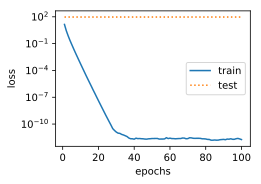

L2 norm of w  14.352234


In [27]:
'''看下过拟合的情况'''
fit_and_plot(0)


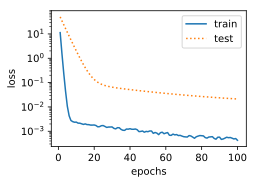

L2 norm of w  0.041139953


In [28]:
'''使用了权重衰减的情况'''
fit_and_plot(3)